In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import copy

import skimage.io as io
from scipy.misc import bytescale

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import merge

Using TensorFlow backend.


In [3]:
from fcn import fcn32_blank, fcn_32s_to_16s, prediction

## Build model architecture

### Fully Convolutional Networks for Semantic Segmentation
##### Jonathan Long, Evan Shelhamer, Trevor Darrell

www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf

Extract from the article relating to the model architecture.

The model is derived from VGG16.

**remark** : deconvolution and conv-transpose are synonyms, they perform up-sampling

#### 4.1. From classifier to dense FCN

We decapitate each net by discarding the final classifier layer [**code comment** : *this is why fc8 is not included*], and convert all fully connected layers to convolutions.

We append a 1x1 convolution with channel dimension 21 [**code comment** : *layer named score_fr*] to predict scores for each of the PASCAL classes (including background) at each of the coarse output locations, followed by a deconvolution layer to bilinearly upsample the coarse outputs to pixel-dense outputs as described in Section 3.3.


#### 4.2. Combining what and where
We define a new fully convolutional net (FCN) for segmentation that combines layers of the feature hierarchy and
refines the spatial precision of the output.
While fully convolutionalized classifiers can be fine-tuned to segmentation as shown in 4.1, and even score highly on the standard metric, their output is dissatisfyingly coarse.
The 32 pixel stride at the final prediction layer limits the scale of detail in the upsampled output.

We address this by adding skips that combine the final prediction layer with lower layers with finer strides.
This turns a line topology into a DAG [**code comment** : *this is why some latter stage layers have 2 inputs*], with edges that skip ahead from lower layers to higher ones.
As they see fewer pixels, the finer scale predictions should need fewer layers, so it makes sense to make them from shallower net outputs.
Combining fine layers and coarse layers lets the model make local predictions that respect global structure.

We first divide the output stride in half by predicting from a 16 pixel stride layer.
We add a 1x1 convolution layer on top of pool4 [**code comment** : *the score_pool4_filter layer*] to produce additional class predictions.
We fuse this output with the predictions computed on top of conv7 (convolutionalized fc7) at stride 32 by adding a 2x upsampling layer and summing [**code comment** : *layer named sum*] both predictions [**code warning** : *requires first layer crop to insure the same size*].

Finally, the stride 16 predictions are upsampled back to the image [**code comment** : *layer named upsample_new*].

We call this net FCN-16s.

### Remark :
**The original paper mention that FCN-8s (slightly more complex architecture) does not provide much improvement so we stopped at FCN-16s**

In [4]:
image_size = 64*8 # INFO: initially tested with 256, 448, 512

In [5]:
fcn32model = fcn32_blank(image_size)

In [6]:
#fcn32model.summary() # visual inspection of model architecture

In [7]:
fcn16model = fcn_32s_to_16s(fcn32model)

E:\Git Repo\Didi2017\fcn.py:119: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(21, name="upsample_new", padding="valid", activation=None, strides=(16, 16), kernel_size=(32, 32))`
  name='upsample_new')


In [8]:
# INFO : dummy image array to test the model passes
imarr = np.ones((image_size,image_size, 3))
imarr = np.expand_dims(imarr, axis=0)

#testmdl = Model(fcn32model.input, fcn32model.layers[10].output) # works fine
testmdl = fcn16model # works fine
testmdl.predict(imarr).shape

(1, 512, 512, 21)

In [9]:
if (testmdl.predict(imarr).shape != (1, image_size, image_size, 21)):
    print('WARNING: size mismatch will impact some test cases')

In [10]:
fcn16model.summary() # visual inspection of model architecture

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
permute_1_input (InputLayer)     (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
permute_1 (Permute)              (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 512, 512, 64)  1792                                         
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 512, 512, 64)  36928                                        
___________________________________________________________________________________________

## Load VGG weigths from .mat file

#### https://www.vlfeat.org/matconvnet/pretrained/#semantic-segmentation
##### Download from console with :
wget https://www.vlfeat.org/matconvnet/models/pascal-fcn16s-dag.mat

In [11]:
from scipy.io import loadmat

In [12]:
data = loadmat('data/pascal-fcn16s-dag.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
p = data['params']
description = data['meta'][0,0].classes[0,0].description

In [13]:
l.shape, p.shape, description.shape

((1, 42), (1, 38), (1, 21))

In [14]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [15]:
if False: # inspection of data structure
    print(dir(l[0,31].block[0,0]))
    print(dir(l[0,36].block[0,0]))

In [16]:
for i in range(0, p.shape[1]-1, 2):
    print(i,
          str(p[0,i].name[0]), p[0,i].value.shape,
          str(p[0,i+1].name[0]), p[0,i+1].value.shape)

0 conv1_1_filter (3, 3, 3, 64) conv1_1_bias (64, 1)
2 conv1_2_filter (3, 3, 64, 64) conv1_2_bias (64, 1)
4 conv2_1_filter (3, 3, 64, 128) conv2_1_bias (128, 1)
6 conv2_2_filter (3, 3, 128, 128) conv2_2_bias (128, 1)
8 conv3_1_filter (3, 3, 128, 256) conv3_1_bias (256, 1)
10 conv3_2_filter (3, 3, 256, 256) conv3_2_bias (256, 1)
12 conv3_3_filter (3, 3, 256, 256) conv3_3_bias (256, 1)
14 conv4_1_filter (3, 3, 256, 512) conv4_1_bias (512, 1)
16 conv4_2_filter (3, 3, 512, 512) conv4_2_bias (512, 1)
18 conv4_3_filter (3, 3, 512, 512) conv4_3_bias (512, 1)
20 conv5_1_filter (3, 3, 512, 512) conv5_1_bias (512, 1)
22 conv5_2_filter (3, 3, 512, 512) conv5_2_bias (512, 1)
24 conv5_3_filter (3, 3, 512, 512) conv5_3_bias (512, 1)
26 fc6_filter (7, 7, 512, 4096) fc6_bias (4096, 1)
28 fc7_filter (1, 1, 4096, 4096) fc7_bias (4096, 1)
30 score_fr_filter (1, 1, 4096, 21) score_fr_bias (21, 1)
32 score2_filter (4, 4, 21, 21) score2_bias (21, 1)
34 score_pool4_filter (1, 1, 512, 21) score_pool4_bias (21,

In [17]:
for i in range(l.shape[1]):
    print(i,
          str(l[0,i].name[0]), str(l[0,i].type[0]),
          [str(n[0]) for n in l[0,i].inputs[0,:]],
          [str(n[0]) for n in l[0,i].outputs[0,:]])

0 conv1_1 dagnn.Conv ['data'] ['conv1_1']
1 relu1_1 dagnn.ReLU ['conv1_1'] ['conv1_1x']
2 conv1_2 dagnn.Conv ['conv1_1x'] ['conv1_2']
3 relu1_2 dagnn.ReLU ['conv1_2'] ['conv1_2x']
4 pool1 dagnn.Pooling ['conv1_2x'] ['pool1']
5 conv2_1 dagnn.Conv ['pool1'] ['conv2_1']
6 relu2_1 dagnn.ReLU ['conv2_1'] ['conv2_1x']
7 conv2_2 dagnn.Conv ['conv2_1x'] ['conv2_2']
8 relu2_2 dagnn.ReLU ['conv2_2'] ['conv2_2x']
9 pool2 dagnn.Pooling ['conv2_2x'] ['pool2']
10 conv3_1 dagnn.Conv ['pool2'] ['conv3_1']
11 relu3_1 dagnn.ReLU ['conv3_1'] ['conv3_1x']
12 conv3_2 dagnn.Conv ['conv3_1x'] ['conv3_2']
13 relu3_2 dagnn.ReLU ['conv3_2'] ['conv3_2x']
14 conv3_3 dagnn.Conv ['conv3_2x'] ['conv3_3']
15 relu3_3 dagnn.ReLU ['conv3_3'] ['conv3_3x']
16 pool3 dagnn.Pooling ['conv3_3x'] ['pool3']
17 conv4_1 dagnn.Conv ['pool3'] ['conv4_1']
18 relu4_1 dagnn.ReLU ['conv4_1'] ['conv4_1x']
19 conv4_2 dagnn.Conv ['conv4_1x'] ['conv4_2']
20 relu4_2 dagnn.ReLU ['conv4_2'] ['conv4_2x']
21 conv4_3 dagnn.Conv ['conv4_2x'] ['co

In [18]:
# documentation for the dagnn.Crop layer :
# https://github.com/vlfeat/matconvnet/blob/master/matlab/%2Bdagnn/Crop.m

In [19]:
def copy_mat_to_keras(kmodel):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (0, 1, 2, 3) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, p.shape[1]-1, 2):
        matname = '_'.join(p[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print('found : ', (str(matname), kindex))
            l_weights = p[0,i].value
            l_bias = p[0,i+1].value
            f_l_weights = l_weights.transpose(prmt)
            f_l_weights = np.flip(f_l_weights, 2)
            f_l_weights = np.flip(f_l_weights, 3)
            print(f_l_weights.shape, kmodel.layers[kindex].get_weights()[0].shape)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
        else:
            print('not found : ', str(matname))

In [20]:
#copy_mat_to_keras(fcn32model)
copy_mat_to_keras(fcn16model)

found :  ('conv1_1', 2)
(3, 3, 3, 64) (3, 3, 3, 64)
found :  ('conv1_2', 3)
(3, 3, 64, 64) (3, 3, 64, 64)
found :  ('conv2_1', 5)
(3, 3, 64, 128) (3, 3, 64, 128)
found :  ('conv2_2', 6)
(3, 3, 128, 128) (3, 3, 128, 128)
found :  ('conv3_1', 8)
(3, 3, 128, 256) (3, 3, 128, 256)
found :  ('conv3_2', 9)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv3_3', 10)
(3, 3, 256, 256) (3, 3, 256, 256)
found :  ('conv4_1', 12)
(3, 3, 256, 512) (3, 3, 256, 512)
found :  ('conv4_2', 13)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv4_3', 14)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_1', 16)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_2', 17)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('conv5_3', 18)
(3, 3, 512, 512) (3, 3, 512, 512)
found :  ('fc6', 20)
(7, 7, 512, 4096) (7, 7, 512, 4096)
found :  ('fc7', 21)
(1, 1, 4096, 4096) (1, 1, 4096, 4096)
found :  ('score_fr', 22)
(1, 1, 4096, 21) (1, 1, 4096, 21)
found :  ('score2', 23)
(4, 4, 21, 21) (4, 4, 21, 21)
found :  ('score_pool

In [22]:
im = Image.open('misc/000121.png') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
# im = im.crop((0,0,319,319)) # WARNING : manual square cropping
im = im.resize((image_size,image_size))

(512, 512, 3)


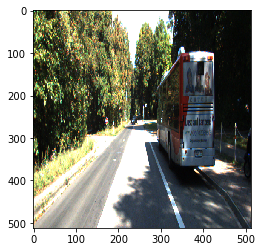

In [23]:
plt.imshow(np.asarray(im))
print(np.asarray(im).shape)

In [24]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit
preds = prediction(fcn16model, crpim, transform=True)

(1, 512, 512, 21)
(512, 512)


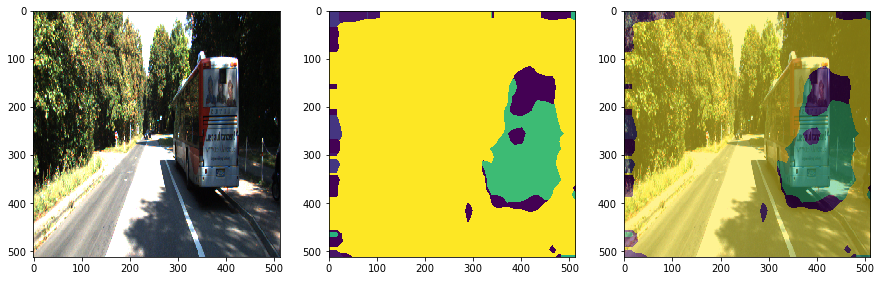

In [25]:
#imperson = preds[0,class2index['person'],:,:]
print(preds.shape)
imclass = np.argmax(preds, axis=3)[0,:,:]
print(imclass.shape)
plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(crpim) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(crpim) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [26]:
# List of dominant classes found in the image
for c in np.unique(imclass):
    print(c, str(description[0,c][0]))

1 aeroplane
2 bicycle
4 boat
13 horse
14 motorbike
15 person
20 tvmonitor


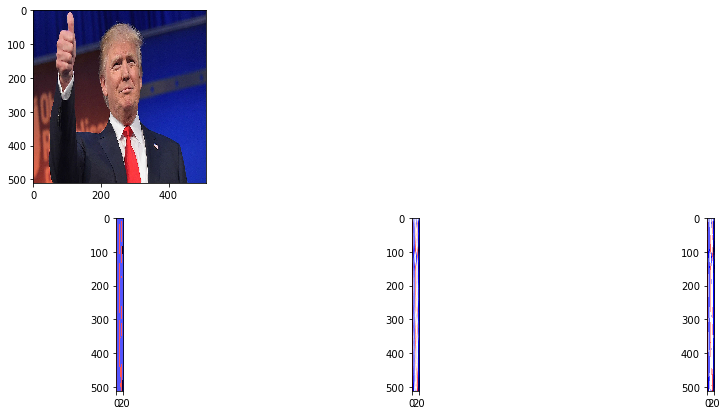

In [37]:
bspreds = bytescale(preds, low=0, high=255)

plt.figure(figsize = (15, 7))
plt.subplot(2,3,1)
plt.imshow(np.asarray(crpim))
plt.subplot(2,3,3+1)
plt.imshow(bspreds[0,class2index['background'],:,:], cmap='seismic')
plt.subplot(2,3,3+2)
plt.imshow(bspreds[0,class2index['person'],:,:], cmap='seismic')
plt.subplot(2,3,3+3)
plt.imshow(bspreds[0,class2index['bicycle'],:,:], cmap='seismic')